In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from math import sqrt
from itertools import chain
import pymc3 as pm
from pymc3 import  *

In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

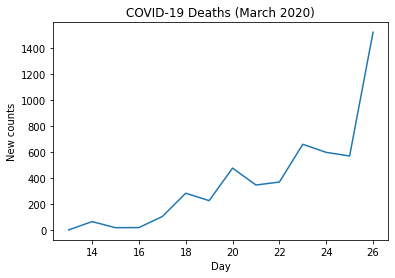

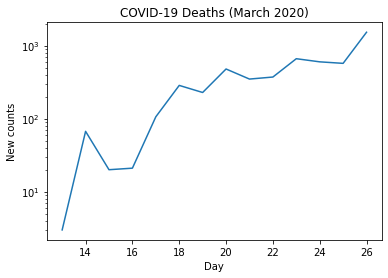

In [2]:
# New York State
days = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
counts = np.array([47, 50, 117, 137, 158, 264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805, 5327])
# Santa Clara County
#days = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
#counts = np.array([1, 2, 2, 4, 5, 6, 6, 8, 8, 10, 13, 16, 17, 19, 20])
new_counts = np.diff(counts)
days = days[1:]
plt.plot(days, new_counts)
plt.ylabel('New counts')
plt.xlabel('Day')
plt.title('COVID-19 Deaths (March 2020)')
plt.show()
plt.semilogy(days, new_counts)
plt.ylabel('New counts')
plt.xlabel('Day')
plt.title('COVID-19 Deaths (March 2020)')
plt.show()

In [3]:
# Bayesian regression model: adapted from https://docs.pymc.io/notebooks/GLM-linear.html
data = dict(x=days, y=np.log(new_counts))
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('y ~ x', data)
    trace_gaussian = sample(3000, cores=2, target_accept=0.95) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:09<00:00, 757.61draws/s]


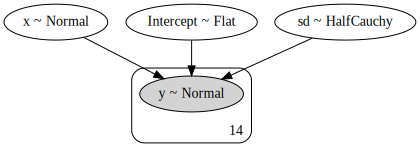

In [4]:
model_to_graphviz(model)

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

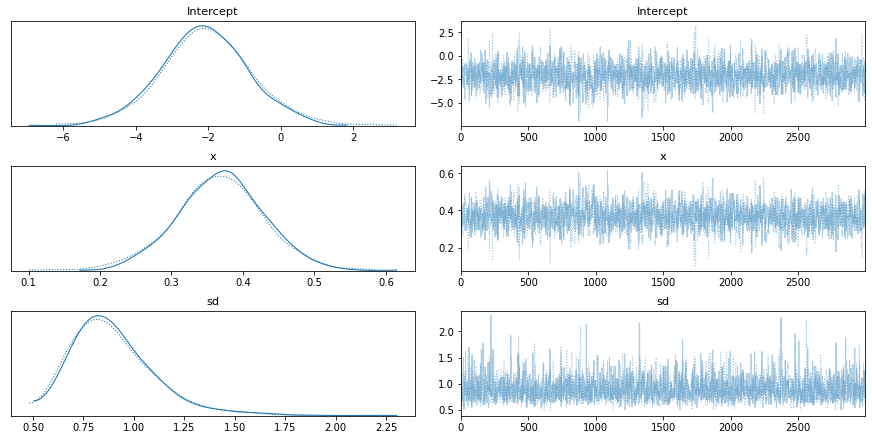

In [5]:
traceplot(trace_gaussian)

In [6]:
print('Median parameter estimate:          %.3f' % np.median(trace_gaussian['x']))
print('5th percentile parameter estimate:  %.3f' % np.quantile(trace_gaussian['x'], 0.05))
print('95th percentile parameter estimate: %.3f' % np.quantile(trace_gaussian['x'], 0.95))
print('Estimated growth rate: %.3f' % (np.exp(np.median(trace_gaussian['x']))-1))

Median parameter estimate:          0.369
5th percentile parameter estimate:  0.265
95th percentile parameter estimate: 0.470
Estimated growth rate: 0.446


Conclusion: under the linear-Gaussian model, the log count is growing at between 0.27 and 0.47 per day, with a median estimate around 0.36. This corresponds to $\exp(0.36)-1 = 44\%$ increase per day.

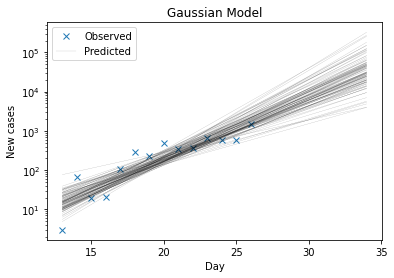

In [7]:
converter = lambda x, sample: np.exp(sample['Intercept'] + sample['x'] * x)
plt.semilogy(days, new_counts, 'x', label='Observed')
plt.xlabel('Day')
plt.ylabel('New cases')
plot_posterior_predictive_glm(trace_gaussian, samples=100, eval=np.arange(13, 35), lm=converter, label='Predicted', alpha=0.4)
plt.title('Gaussian Model')
plt.legend()

In [8]:
# Alternative Bayesian model with Poisson likelihood
data = dict(x=days, y=new_counts)
with Model() as model:
    glm.GLM.from_formula('y ~ x', data, family=glm.families.Poisson()) 
    # Poisson automatically uses exponential link function to keep things positive
    trace_poisson = sample(3000, cores=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:13<00:00, 500.60draws/s]


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

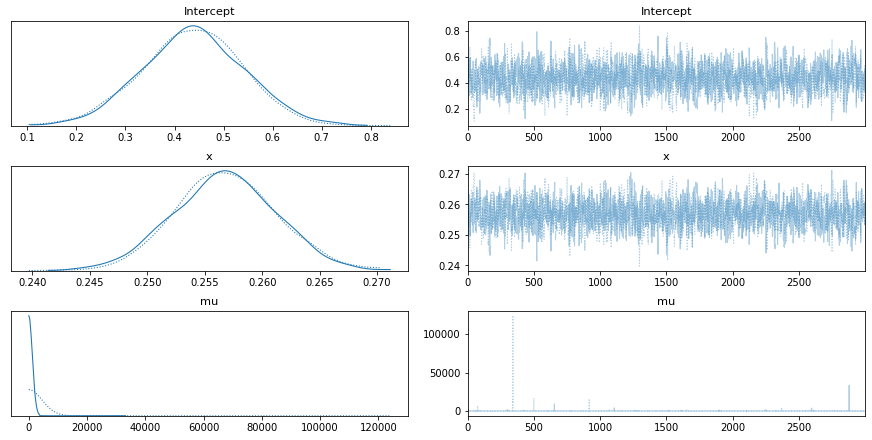

In [9]:
traceplot(trace_poisson)

Median parameter estimate:          0.257
5th percentile parameter estimate:  0.250
95th percentile parameter estimate: 0.264
Estimated growth rate: 0.293


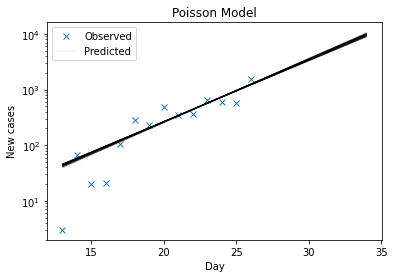

In [10]:
plt.semilogy(days, new_counts, 'x', label='Observed')
plt.xlabel('Day')
plt.ylabel('New cases')
plot_posterior_predictive_glm(trace_poisson, samples=100, eval=np.arange(13, 35), lm=converter, label='Predicted', alpha=0.4)
plt.title('Poisson Model')
plt.legend()
print('Median parameter estimate:          %.3f' % np.median(trace_poisson['x']))
print('5th percentile parameter estimate:  %.3f' % np.quantile(trace_poisson['x'], 0.05))
print('95th percentile parameter estimate: %.3f' % np.quantile(trace_poisson['x'], 0.95))
print('Estimated growth rate: %.3f' % (np.exp(np.median(trace_poisson['x']))-1))

In [11]:
# Alternative Bayesian model with Negative Binomial likelihood
data = dict(x=days, y=new_counts)
with Model() as model:
    glm.GLM.from_formula('y ~ x', data, family=glm.families.NegativeBinomial()) 
    # Poisson automatically uses exponential link function to keep things positive
    trace_nb = sample(3000, cores=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:15<00:00, 455.17draws/s]


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

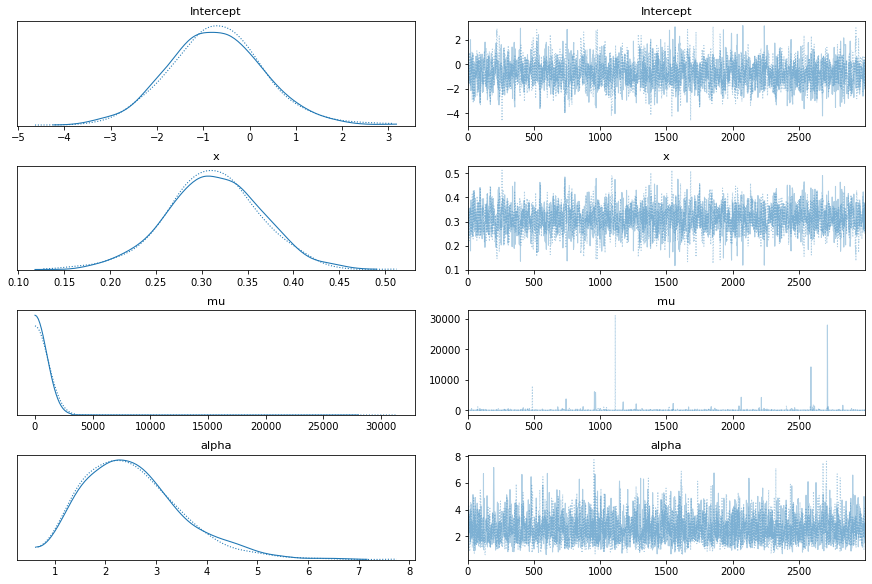

In [12]:
traceplot(trace_nb)

Median parameter estimate:          0.313
5th percentile parameter estimate:  0.225
95th percentile parameter estimate: 0.399
Estimated growth rate: 0.367


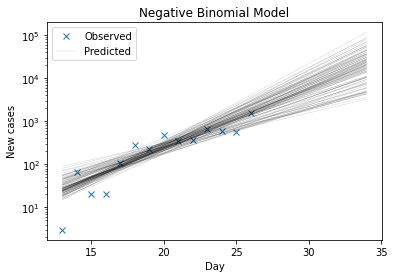

In [13]:
plt.semilogy(days, new_counts, 'x', label='Observed')
plt.xlabel('Day')
plt.ylabel('New cases')
plot_posterior_predictive_glm(trace_nb, samples=100, eval=np.arange(13, 35), lm=converter, label='Predicted', alpha=0.4)
plt.title('Negative Binomial Model')
plt.legend()
print('Median parameter estimate:          %.3f' % np.median(trace_nb['x']))
print('5th percentile parameter estimate:  %.3f' % np.quantile(trace_nb['x'], 0.05))
print('95th percentile parameter estimate: %.3f' % np.quantile(trace_nb['x'], 0.95))
print('Estimated growth rate: %.3f' % (np.exp(np.median(trace_nb['x']))-1))